# Imports

In [2]:
!pip install -q /kaggle/input/tensorflow-2120/tensorflow-2.12.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!pip install -q tensorflow-addons==0.20.0
!pip install -q git+https://github.com/hoyso48/tf-utils@main

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow.keras.mixed_precision as mixed_precision

from tqdm.autonotebook import tqdm
import sklearn

from tf_utils.schedules import OneCycleLR, ListedLR
from tf_utils.callbacks import Snapshot, SWA
from tf_utils.learners import FGM, AWP

import os
import time
import pickle
import math
import random
import sys
import cv2
import gc
import glob
import datetime

print(f'Tensorflow Version: {tf.__version__}')
print(f'Python Version: {sys.version}')

D0420 15:54:24.383456641      15 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0420 15:54:24.383480079      15 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0420 15:54:24.383483439      15 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0420 15:54:24.383486146      15 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0420 15:54:24.383488563      15 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0420 15:54:24.383506941      15 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0420 15:54:24.383513359      15 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0420 15:54:24.

Tensorflow Version: 2.12.0
Python Version: 3.8.16 (default, Apr 12 2023, 14:58:47) 
[GCC 10.2.1 20210110]


In [4]:
# Seed all random number generators, for consistency
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

# Using TPUs on Kaggle
def get_strategy(device='TPU-VM'):
    if "TPU" in device:
        tpu = 'local' if device=='TPU-VM' else None
        print("connecting to TPU...")
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu=tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
        IS_TPU = True

    if device == "GPU"  or device=="CPU":
        ngpu = len(tf.config.experimental.list_physical_devices('GPU'))
        if ngpu>1:
            print("Using multi GPU")
            strategy = tf.distribute.MirroredStrategy()
        elif ngpu==1:
            print("Using single GPU")
            strategy = tf.distribute.get_strategy()
        else:
            print("Using CPU")
            strategy = tf.distribute.get_strategy()
            CFG.device = "CPU"

    if device == "GPU":
        print("Num GPUs Available: ", ngpu)

    AUTO     = tf.data.experimental.AUTOTUNE
    REPLICAS = strategy.num_replicas_in_sync
    print(f'REPLICAS: {REPLICAS}')
    
    return strategy, REPLICAS, IS_TPU

STRATEGY, N_REPLICAS, IS_TPU = get_strategy()

connecting to TPU...
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/tas

In [7]:
# For training, validation, and test we will use the randomly split 5-fold tfrecords data.
# This data is meant to be used for 5-fold cross validation training, but we will only be training for one fold due to time constraints.
TRAIN_FILENAMES = glob.glob('/kaggle/input/islr-5fold/*.tfrecords')
print(len(TRAIN_FILENAMES))

187


In [11]:
# Train DataFrame, for visualisation
train_df = pd.read_csv('/kaggle/input/asl-signs/train.csv')
display(train_df.head())
display(train_df.info())

,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94477 entries, 0 to 94476
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   path            94477 non-null  object
 1   participant_id  94477 non-null  int64 
 2   sequence_id     94477 non-null  int64 
 3   sign            94477 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.9+ MB


None

In [12]:
import re
# Allows us to count exact number of items in original csv file, to make sure it corresponds to the tf records in the split dataset used for 5-fold training
# We have 94477 sequences/samples in total.
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename.split('/')[-1]).group(1)) for filename in filenames]
    return np.sum(n)
print(count_data_items(TRAIN_FILENAMES), len(train_df))
assert count_data_items(TRAIN_FILENAMES) == len(train_df)

94477 94477


# Preprocessing functions - explained in training-ryan.ipynb

In [13]:
ROWS_PER_FRAME = 543
MAX_LEN = 384
CROP_LEN = MAX_LEN
NUM_CLASSES  = 250
PAD = -100.
NOSE=[
    1,2,98,327
]
LNOSE = [98]
RNOSE = [327]
LIP = [ 0, 
    61, 185, 40, 39, 37, 267, 269, 270, 409,
    291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
    78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
    95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
]
LLIP = [84,181,91,146,61,185,40,39,37,87,178,88,95,78,191,80,81,82]
RLIP = [314,405,321,375,291,409,270,269,267,317,402,318,324,308,415,310,311,312]

POSE = [500, 502, 504, 501, 503, 505, 512, 513]
LPOSE = [513,505,503,501]
RPOSE = [512,504,502,500]

REYE = [
    33, 7, 163, 144, 145, 153, 154, 155, 133,
    246, 161, 160, 159, 158, 157, 173,
]
LEYE = [
    263, 249, 390, 373, 374, 380, 381, 382, 362,
    466, 388, 387, 386, 385, 384, 398,
]

LHAND = np.arange(468, 489).tolist()
RHAND = np.arange(522, 543).tolist()

POINT_LANDMARKS = LIP + LHAND + RHAND + NOSE + REYE + LEYE #+POSE

NUM_NODES = len(POINT_LANDMARKS)
CHANNELS = 6*NUM_NODES

print(NUM_NODES)
print(CHANNELS)

def interp1d_(x, target_len, method='random'):
    length = tf.shape(x)[1]
    target_len = tf.maximum(1,target_len)
    if method == 'random':
        if tf.random.uniform(()) < 0.33:
            x = tf.image.resize(x, (target_len,tf.shape(x)[1]),'bilinear')
        else:
            if tf.random.uniform(()) < 0.5:
                x = tf.image.resize(x, (target_len,tf.shape(x)[1]),'bicubic')
            else:
                x = tf.image.resize(x, (target_len,tf.shape(x)[1]),'nearest')
    else:
        x = tf.image.resize(x, (target_len,tf.shape(x)[1]),method)
    return x

def tf_nan_mean(x, axis=0, keepdims=False):
    return tf.reduce_sum(tf.where(tf.math.is_nan(x), tf.zeros_like(x), x), axis=axis, keepdims=keepdims) / tf.reduce_sum(tf.where(tf.math.is_nan(x), tf.zeros_like(x), tf.ones_like(x)), axis=axis, keepdims=keepdims)

def tf_nan_std(x, center=None, axis=0, keepdims=False):
    if center is None:
        center = tf_nan_mean(x, axis=axis,  keepdims=True)
    d = x - center
    return tf.math.sqrt(tf_nan_mean(d * d, axis=axis, keepdims=keepdims))

class Preprocess(tf.keras.layers.Layer):
    def __init__(self, max_len=MAX_LEN, point_landmarks=POINT_LANDMARKS, **kwargs):
        super().__init__(**kwargs)
        self.max_len = max_len
        self.point_landmarks = point_landmarks

    def call(self, inputs):
        if tf.rank(inputs) == 3:
            x = inputs[None,...]
        else:
            x = inputs
        
        mean = tf_nan_mean(tf.gather(x, [17], axis=2), axis=[1,2], keepdims=True)
        mean = tf.where(tf.math.is_nan(mean), tf.constant(0.5,x.dtype), mean)
        x = tf.gather(x, self.point_landmarks, axis=2) #N,T,P,C
        std = tf_nan_std(x, center=mean, axis=[1,2], keepdims=True)
        
        x = (x - mean)/std

        if self.max_len is not None:
            x = x[:,:self.max_len]
        length = tf.shape(x)[1]
        x = x[...,:2]

        dx = tf.cond(tf.shape(x)[1]>1,lambda:tf.pad(x[:,1:] - x[:,:-1], [[0,0],[0,1],[0,0],[0,0]]),lambda:tf.zeros_like(x))

        dx2 = tf.cond(tf.shape(x)[1]>2,lambda:tf.pad(x[:,2:] - x[:,:-2], [[0,0],[0,2],[0,0],[0,0]]),lambda:tf.zeros_like(x))

        x = tf.concat([
            tf.reshape(x, (-1,length,2*len(self.point_landmarks))),
            tf.reshape(dx, (-1,length,2*len(self.point_landmarks))),
            tf.reshape(dx2, (-1,length,2*len(self.point_landmarks))),
        ], axis = -1)
        
        x = tf.where(tf.math.is_nan(x),tf.constant(0.,x.dtype),x)
        
        return x

118
708


In [15]:
def decode_tfrec(record_bytes):
    features = tf.io.parse_single_example(record_bytes, {
        'coordinates': tf.io.FixedLenFeature([], tf.string),
        'sign': tf.io.FixedLenFeature([], tf.int64),
    })
    out = {}
    out['coordinates']  = tf.reshape(tf.io.decode_raw(features['coordinates'], tf.float32), (-1,ROWS_PER_FRAME,3))
    out['sign'] = features['sign']
    return out

def filter_nans_tf(x, ref_point=POINT_LANDMARKS):
    mask = tf.math.logical_not(tf.reduce_all(tf.math.is_nan(tf.gather(x,ref_point,axis=1)), axis=[-2,-1]))
    x = tf.boolean_mask(x, mask, axis=0)
    return x

def preprocess(x, augment=False, max_len=MAX_LEN):
    coord = x['coordinates']
    coord = filter_nans_tf(coord)
    if augment:
        coord = augment_fn(coord, max_len=max_len)
    coord = tf.ensure_shape(coord, (None,ROWS_PER_FRAME,3))
    
    return tf.cast(Preprocess(max_len=max_len)(coord)[0],tf.float32), tf.one_hot(x['sign'], NUM_CLASSES)

def flip_lr(x):
    x,y,z = tf.unstack(x, axis=-1)
    x = 1-x
    new_x = tf.stack([x,y,z], -1)
    new_x = tf.transpose(new_x, [1,0,2])
    lhand = tf.gather(new_x, LHAND, axis=0)
    rhand = tf.gather(new_x, RHAND, axis=0)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(LHAND)[...,None], rhand)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(RHAND)[...,None], lhand)
    llip = tf.gather(new_x, LLIP, axis=0)
    rlip = tf.gather(new_x, RLIP, axis=0)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(LLIP)[...,None], rlip)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(RLIP)[...,None], llip)
    lpose = tf.gather(new_x, LPOSE, axis=0)
    rpose = tf.gather(new_x, RPOSE, axis=0)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(LPOSE)[...,None], rpose)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(RPOSE)[...,None], lpose)
    leye = tf.gather(new_x, LEYE, axis=0)
    reye = tf.gather(new_x, REYE, axis=0)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(LEYE)[...,None], reye)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(REYE)[...,None], leye)
    lnose = tf.gather(new_x, LNOSE, axis=0)
    rnose = tf.gather(new_x, RNOSE, axis=0)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(LNOSE)[...,None], rnose)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(RNOSE)[...,None], lnose)
    new_x = tf.transpose(new_x, [1,0,2])
    return new_x

def resample(x, rate=(0.8,1.2)):
    rate = tf.random.uniform((), rate[0], rate[1])
    length = tf.shape(x)[0]
    new_size = tf.cast(rate*tf.cast(length,tf.float32), tf.int32)
    new_x = interp1d_(x, new_size)
    return new_x

def spatial_random_affine(xyz,
    scale  = (0.8,1.2),
    shear = (-0.15,0.15),
    shift  = (-0.1,0.1),
    degree = (-30,30),
):
    center = tf.constant([0.5,0.5])
    if scale is not None:
        scale = tf.random.uniform((),*scale)
        xyz = scale*xyz

    if shear is not None:
        xy = xyz[...,:2]
        z = xyz[...,2:]
        shear_x = shear_y = tf.random.uniform((),*shear)
        if tf.random.uniform(()) < 0.5:
            shear_x = 0.
        else:
            shear_y = 0.
        shear_mat = tf.identity([
            [1.,shear_x],
            [shear_y,1.]
        ])
        xy = xy @ shear_mat
        center = center + [shear_y, shear_x]
        xyz = tf.concat([xy,z], axis=-1)

    if degree is not None:
        xy = xyz[...,:2]
        z = xyz[...,2:]
        xy -= center
        degree = tf.random.uniform((),*degree)
        radian = degree/180*np.pi
        c = tf.math.cos(radian)
        s = tf.math.sin(radian)
        rotate_mat = tf.identity([
            [c,s],
            [-s, c],
        ])
        xy = xy @ rotate_mat
        xy = xy + center
        xyz = tf.concat([xy,z], axis=-1)

    if shift is not None:
        shift = tf.random.uniform((),*shift)
        xyz = xyz + shift

    return xyz

def temporal_crop(x, length=MAX_LEN):
    l = tf.shape(x)[0]
    offset = tf.random.uniform((), 0, tf.clip_by_value(l-length,1,length), dtype=tf.int32)
    x = x[offset:offset+length]
    return x

def temporal_mask(x, size=(0.2,0.4), mask_value=float('nan')):
    l = tf.shape(x)[0]
    mask_size = tf.random.uniform((), *size)
    mask_size = tf.cast(tf.cast(l, tf.float32) * mask_size, tf.int32)
    mask_offset = tf.random.uniform((), 0, tf.clip_by_value(l-mask_size,1,l), dtype=tf.int32)
    x = tf.tensor_scatter_nd_update(x,tf.range(mask_offset, mask_offset+mask_size)[...,None],tf.fill([mask_size,543,3],mask_value))
    return x

def spatial_mask(x, size=(0.2,0.4), mask_value=float('nan')):
    mask_offset_y = tf.random.uniform(())
    mask_offset_x = tf.random.uniform(())
    mask_size = tf.random.uniform((), *size)
    mask_x = (mask_offset_x<x[...,0]) & (x[...,0] < mask_offset_x + mask_size)
    mask_y = (mask_offset_y<x[...,1]) & (x[...,1] < mask_offset_y + mask_size)
    mask = mask_x & mask_y
    x = tf.where(mask[...,None], mask_value, x)
    return x

def augment_fn(x, always=False, max_len=None):
    print("Preprocessing...")
    if tf.random.uniform(())<0.8 or always:
        print("Resample applied")
        x = resample(x, (0.5,1.5))
    if tf.random.uniform(())<0.5 or always:
        print("Flip applied")
        x = flip_lr(x)
    if max_len is not None:
        print("Temporal crop applied")
        x = temporal_crop(x, max_len)
    if tf.random.uniform(())<0.75 or always:
        print("Spatial random affine applied")
        x = spatial_random_affine(x)
    if tf.random.uniform(())<0.5 or always:
        print("Temporal mask applied")
        x = temporal_mask(x)
    if tf.random.uniform(())<0.5 or always:
        print("Spatial mask applied")
        x = spatial_mask(x)
    return x

def get_tfrec_dataset(tfrecords, batch_size=64, max_len=64, drop_remainder=False, augment=False, shuffle=False, repeat=False):
    # Initialize dataset with TFRecords
    ds = tf.data.TFRecordDataset(tfrecords, num_parallel_reads=tf.data.AUTOTUNE, compression_type='GZIP')
    # Decodes serialized TFRecord entries (e.g., converting binary to usable features).
    ds = ds.map(decode_tfrec, tf.data.AUTOTUNE)
    # Applies above preprocessing logic
    ds = ds.map(lambda x: preprocess(x, augment=augment, max_len=max_len), tf.data.AUTOTUNE)

    # Enables epoch-wise repetition
    if repeat: 
        ds = ds.repeat()

    # Enables epoch-wise shuffling
    if shuffle:
        ds = ds.shuffle(shuffle)
        options = tf.data.Options()
        options.experimental_deterministic = (False)
        ds = ds.with_options(options)

    # Batches and pads variable-length data to a uniform shape: [batch_size, max_len, CHANNELS]
    if batch_size:
        ds = ds.padded_batch(batch_size, padding_values=PAD, padded_shapes=([max_len,CHANNELS],[NUM_CLASSES]), drop_remainder=drop_remainder)

    # Enables background data loading to optimize training speed
    ds = ds.prefetch(tf.data.AUTOTUNE)
        
    return ds

# Checking to see if dataloader is able to iterate over dataset without error
ds = get_tfrec_dataset(TRAIN_FILENAMES, augment=False, batch_size=1024)
for x in ds:
    temp_train = x
    break

# Model

Our best-performing model includes the following layers:

**ECA**: introduces lightweight attention across channels to help the model focus on more informative features. It first compresses temporal information using global average pooling, then applies a 1D convolution to model interactions between channels. After a sigmoid activation, the resulting weights are used to scale the original input features channel-wise, enhancing the most relevant parts of the signal.

**LateDropout** delays the application of dropout until a specified number of training steps have passed. This helps the model stabilize in early training before introducing regularization. Once the step threshold is reached, it applies standard dropout during training, reducing overfitting by randomly zeroing out portions of the input.

**CausalDWConv1D**: performs causal, depthwise 1D convolution with dilation, meaning each output at time t only depends on inputs at time t and earlier (important for autoregressive models). It applies zero-padding to maintain sequence length and uses a depthwise convolution to filter each input channel separately, preserving temporal structure while being computationally efficient.

**Conv1DBlock**: a modular block designed for efficient 1D sequence modeling. It first expands the feature dimension, applies a depthwise convolution via CausalDWConv1D, followed by batch normalization and channel attention using ECA. It then projects the features back to the target size and includes residual connections if input and output dimensions match. Dropout is applied optionally for regularization. This block combines efficiency with representational power, making it ideal for deep temporal models.

**MultiHeadSelfAttention**: implements multi-head self-attention, a key component of transformers. It learns to focus on different parts of the input sequence by projecting the input into query (Q), key (K), and value (V) vectors using a single dense layer. These are split into multiple attention heads to capture diverse relationships. Attention scores are computed using scaled dot-product, optionally masked, normalized with softmax, and applied to the value vectors. Finally, outputs from all heads are combined and projected back to the original dimension. Dropout is used to regularize the attention weights.

**TransformerBlock**: wraps multi-head self-attention and a feed-forward network with normalization, residual connections, and dropout for stability and regularization. It first normalizes inputs and applies attention, adds a residual connection, then feeds the output into a two-layer feed-forward network that expands and reduces the feature dimension. Another residual connection ensures better gradient flow. This structure allows the model to learn both local and global temporal patterns effectively while staying robust during training.

Our other models (1DCNN only, Transformers only, 1DCNN + LSTM, 1DCNN + GRU) are also available to be chosen for training, just change the model instantiated to the one that you want. Note that our LSTM and GRU layers are not supported with 

Below are all the definitions for model layers that we will use in our different types of models. This includes the ECA layer, LateDropout layer, CausalDWConv1D layer, COnv1DBlock layer,MultiHeadSelfAttention layer,TransformerBlock layer, LSTM layer, and GRU layer.

In [16]:
class ECA(tf.keras.layers.Layer):
    def __init__(self, kernel_size=5, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True
        self.kernel_size = kernel_size
        self.conv = tf.keras.layers.Conv1D(1, kernel_size=kernel_size, strides=1, padding="same", use_bias=False)

    def call(self, inputs, mask=None):
        nn = tf.keras.layers.GlobalAveragePooling1D()(inputs, mask=mask)
        nn = tf.expand_dims(nn, -1)
        nn = self.conv(nn)
        nn = tf.squeeze(nn, -1)
        nn = tf.nn.sigmoid(nn)
        nn = nn[:,None,:]
        return inputs * nn

class LateDropout(tf.keras.layers.Layer):
    def __init__(self, rate, noise_shape=None, start_step=0, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True
        self.rate = rate
        self.start_step = start_step
        self.dropout = tf.keras.layers.Dropout(rate, noise_shape=noise_shape)
      
    def build(self, input_shape):
        super().build(input_shape)
        agg = tf.VariableAggregation.ONLY_FIRST_REPLICA
        self._train_counter = tf.Variable(0, dtype="int64", aggregation=agg, trainable=False)

    def call(self, inputs, training=False):
        x = tf.cond(self._train_counter < self.start_step, lambda:inputs, lambda:self.dropout(inputs, training=training))
        if training:
            self._train_counter.assign_add(1)
        return x

class CausalDWConv1D(tf.keras.layers.Layer):
    def __init__(self, 
        kernel_size=17,
        dilation_rate=1,
        use_bias=False,
        depthwise_initializer='glorot_uniform',
        name='', **kwargs):
        super().__init__(name=name,**kwargs)
        self.causal_pad = tf.keras.layers.ZeroPadding1D((dilation_rate*(kernel_size-1),0),name=name + '_pad')
        self.dw_conv = tf.keras.layers.DepthwiseConv1D(
                            kernel_size,
                            strides=1,
                            dilation_rate=dilation_rate,
                            padding='valid',
                            use_bias=use_bias,
                            depthwise_initializer=depthwise_initializer,
                            name=name + '_dwconv')
        self.supports_masking = True
        
    def call(self, inputs):
        x = self.causal_pad(inputs)
        x = self.dw_conv(x)
        return x

def Conv1DBlock(channel_size,
          kernel_size,
          dilation_rate=1,
          drop_rate=0.0,
          expand_ratio=2,
          se_ratio=0.25,
          activation='swish',
          name=None):
    '''
    efficient conv1d block, @hoyso48
    '''
    if name is None:
        name = str(tf.keras.backend.get_uid("mbblock"))
    # Expansion phase
    def apply(inputs):
        channels_in = tf.keras.backend.int_shape(inputs)[-1]
        channels_expand = channels_in * expand_ratio

        skip = inputs

        x = tf.keras.layers.Dense(
            channels_expand,
            use_bias=True,
            activation=activation,
            name=name + '_expand_conv')(inputs)

        # Depthwise Convolution
        x = CausalDWConv1D(kernel_size,
            dilation_rate=dilation_rate,
            use_bias=False,
            name=name + '_dwconv')(x)

        x = tf.keras.layers.BatchNormalization(momentum=0.95, name=name + '_bn')(x)

        x  = ECA()(x)

        x = tf.keras.layers.Dense(
            channel_size,
            use_bias=True,
            name=name + '_project_conv')(x)

        if drop_rate > 0:
            x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None,1,1), name=name + '_drop')(x)

        if (channels_in == channel_size):
            x = tf.keras.layers.add([x, skip], name=name + '_add')
        return x

    return apply

In [17]:
class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, dim=256, num_heads=4, dropout=0, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        self.scale = self.dim ** -0.5
        self.num_heads = num_heads
        self.qkv = tf.keras.layers.Dense(3 * dim, use_bias=False)
        self.drop1 = tf.keras.layers.Dropout(dropout)
        self.proj = tf.keras.layers.Dense(dim, use_bias=False)
        self.supports_masking = True

    def call(self, inputs, mask=None):
        qkv = self.qkv(inputs)
        qkv = tf.keras.layers.Permute((2, 1, 3))(tf.keras.layers.Reshape((-1, self.num_heads, self.dim * 3 // self.num_heads))(qkv))
        q, k, v = tf.split(qkv, [self.dim // self.num_heads] * 3, axis=-1)

        attn = tf.matmul(q, k, transpose_b=True) * self.scale

        if mask is not None:
            mask = mask[:, None, None, :]

        attn = tf.keras.layers.Softmax(axis=-1)(attn, mask=mask)
        attn = self.drop1(attn)

        x = attn @ v
        x = tf.keras.layers.Reshape((-1, self.dim))(tf.keras.layers.Permute((2, 1, 3))(x))
        x = self.proj(x)
        return x


def TransformerBlock(dim=256, num_heads=4, expand=4, attn_dropout=0.2, drop_rate=0.2, activation='swish'):
    def apply(inputs):
        x = inputs
        x = tf.keras.layers.BatchNormalization(momentum=0.95)(x)
        x = MultiHeadSelfAttention(dim=dim,num_heads=num_heads,dropout=attn_dropout)(x)
        x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None,1,1))(x)
        x = tf.keras.layers.Add()([inputs, x])
        attn_out = x

        x = tf.keras.layers.BatchNormalization(momentum=0.95)(x)
        x = tf.keras.layers.Dense(dim*expand, use_bias=False, activation=activation)(x)
        x = tf.keras.layers.Dense(dim, use_bias=False)(x)
        x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None,1,1))(x)
        x = tf.keras.layers.Add()([attn_out, x])
        return x
    return apply

In [18]:
class LSTM(tf.keras.layers.Layer):
    def __init__(self, units, bidirectional=True, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.bidirectional = bidirectional
        self.supports_masking = True

        if bidirectional:
            self.lstm = tf.keras.layers.Bidirectional(
                tf.keras.layers.LSTM(units, return_sequences=True, dtype='float32')
            )
        else:
            self.lstm = tf.keras.layers.LSTM(units, return_sequences=True, dtype='float32')

    def call(self, inputs, mask=None):
        inputs = tf.cast(inputs, tf.float32)  # Cast to float32 for compatibility
        return self.lstm(inputs, mask=mask)

In [19]:
class GRU(tf.keras.layers.Layer):
    def __init__(self, units, bidirectional=True, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.bidirectional = bidirectional
        self.supports_masking = True

        if bidirectional:
            self.gru = tf.keras.layers.Bidirectional(
                tf.keras.layers.GRU(units, return_sequences=True, dtype='float32')
            )
        else:
            self.gru = tf.keras.layers.GRU(units, return_sequences=True, dtype='float32')

    def call(self, inputs, mask=None):
        inputs = tf.cast(inputs, tf.float32)   # Cast to float32 for compatibility
        return self.gru(inputs, mask=mask) 

Below are all the model definitions for different types of models.

In [23]:
def cnn_transformers_model(max_len=64, dropout_step=0, dim=192):
    inp = tf.keras.Input((max_len,CHANNELS))
    x = tf.keras.layers.Masking(mask_value=PAD,input_shape=(max_len,CHANNELS))(inp)
    ksize = 17
    x = tf.keras.layers.Dense(dim, use_bias=False,name='stem_conv')(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.95,name='stem_bn')(x)

    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = TransformerBlock(dim,expand=2)(x)

    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = TransformerBlock(dim,expand=2)(x)

    if dim == 384: #for the 4x sized model
        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = TransformerBlock(dim,expand=2)(x)

        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = TransformerBlock(dim,expand=2)(x)

    x = tf.keras.layers.Dense(dim*2,activation=None,name='top_conv')(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = LateDropout(0.8, start_step=dropout_step)(x)
    x = tf.keras.layers.Dense(NUM_CLASSES,name='classifier')(x)
    return tf.keras.Model(inp, x)

def cnn_lstm_model(max_len=64, dropout_step=0, dim=192):
    inp = tf.keras.Input((max_len,CHANNELS))
    x = tf.keras.layers.Masking(mask_value=PAD,input_shape=(max_len,CHANNELS))(inp)
    ksize = 17
    x = tf.keras.layers.Dense(dim, use_bias=False,name='stem_conv')(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.95,name='stem_bn')(x)

    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = LSTM(dim)(x)

    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = LSTM(dim)(x)

    if dim == 384: #for the 4x sized model
        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = LSTM(dim)(x)

        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = LSTM(dim)(x)

    x = tf.keras.layers.Dense(dim*2,activation=None,name='top_conv')(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = LateDropout(0.8, start_step=dropout_step)(x)
    x = tf.keras.layers.Dense(NUM_CLASSES,name='classifier')(x)
    return tf.keras.Model(inp, x)

def cnn_gru_model(max_len=64, dropout_step=0, dim=192):
    inp = tf.keras.Input((max_len,CHANNELS))
    x = tf.keras.layers.Masking(mask_value=PAD,input_shape=(max_len,CHANNELS))(inp)
    ksize = 17
    x = tf.keras.layers.Dense(dim, use_bias=False,name='stem_conv')(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.95,name='stem_bn')(x)

    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = GRU(dim)(x)

    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = GRU(dim)(x)

    if dim == 384: #for the 4x sized model
        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = GRU(dim)(x)

        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = GRU(dim)(x)

    x = tf.keras.layers.Dense(dim*2,activation=None,name='top_conv')(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = LateDropout(0.8, start_step=dropout_step)(x)
    x = tf.keras.layers.Dense(NUM_CLASSES,name='classifier')(x)
    return tf.keras.Model(inp, x)

def cnn_model(max_len=64, dropout_step=0, dim=192):
    inp = tf.keras.Input((max_len,CHANNELS))
    x = tf.keras.layers.Masking(mask_value=PAD,input_shape=(max_len,CHANNELS))(inp)
    ksize = 17
    x = tf.keras.layers.Dense(dim, use_bias=False,name='stem_conv')(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.95,name='stem_bn')(x)

    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)

    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)

    if dim == 384: #for the 4x sized model
        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)

        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)

    x = tf.keras.layers.Dense(dim*2,activation=None,name='top_conv')(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = LateDropout(0.8, start_step=dropout_step)(x)
    x = tf.keras.layers.Dense(NUM_CLASSES,name='classifier')(x)
    return tf.keras.Model(inp, x)

def transformers_model(max_len=64, dropout_step=0, dim=192):
    inp = tf.keras.Input((max_len,CHANNELS))
    x = tf.keras.layers.Masking(mask_value=PAD,input_shape=(max_len,CHANNELS))(inp)
    ksize = 17
    x = tf.keras.layers.Dense(dim, use_bias=False,name='stem_conv')(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.95,name='stem_bn')(x)

    x = TransformerBlock(dim,expand=2)(x)
    x = TransformerBlock(dim,expand=2)(x)

    if dim == 384: #for the 4x sized model
        x = TransformerBlock(dim,expand=2)(x)
        x = TransformerBlock(dim,expand=2)(x)

    x = tf.keras.layers.Dense(dim*2,activation=None,name='top_conv')(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = LateDropout(0.8, start_step=dropout_step)(x)
    x = tf.keras.layers.Dense(NUM_CLASSES,name='classifier')(x)
    return tf.keras.Model(inp, x)

In [25]:
def get_model(model_int=1, max_len=64, dropout_step=0, dim=192):
    if model_int == 1:
        return cnn_transformers_model(max_len=max_len, dropout_step=dropout_step, dim=dim)
    elif model_int == 2:
        return cnn_lstm_model(max_len=max_len, dropout_step=dropout_step, dim=dim)
    elif model_int == 3:
        return cnn_gru_model(max_len=max_len, dropout_step=dropout_step, dim=dim)
    elif model_int == 4:
        return cnn_model(max_len=max_len, dropout_step=dropout_step, dim=dim)
    elif model_int == 5:
        return transformers_model(max_len=max_len, dropout_step=dropout_step, dim=dim)
    else:
        return cnn_transformers_model(max_len=max_len, dropout_step=dropout_step, dim=dim)

In [26]:
# You can change the arguments to get_model() to change the type of model
# 1: cnn_transformers_model
# 2: cnn_lstm_model
# 3: cnn_gru_model
# 4: cnn_model
# 5: transformers_model
# Default is cnn_transformers_model

model = get_model(model_int=1)

# Check supports_masking. This tells model to ignore the masked timesteps during computations like attention or state updates.
for x in model.layers:
    if not x.supports_masking:
        print(x.supports_masking, x.name)

# Training

Our model is able to be trained in folds. Due to compute limitations on Kaggle, we will only be doing one fold over 120 epochs.

**Data split**: We used a downloaded pre-split 5-fold data split, but split the validation set equally into a validation, and a test set. There are 140 files in the train set, 23 files in the validation set, and 24 files in the test set. There are altogether 94477 instances of sequences grouped in all the pre-split 5-fold data files.

**Evaluation metrics used**: Categorical accuracy, Top-5 accuracy, Micro F1 and Macro F1 scores.

In [27]:
from sklearn.metrics import f1_score

def train_fold(CFG, fold, train_files, valid_files=None, test_files=None, model_int=1, strategy=STRATEGY, summary=True):
    seed_everything(CFG.seed)
    tf.keras.backend.clear_session()
    gc.collect()
    tf.config.optimizer.set_jit(True)
        
    if CFG.fp16:
        try:
            policy = mixed_precision.Policy('mixed_bfloat16')
            mixed_precision.set_global_policy(policy)
        except:
            policy = mixed_precision.Policy('mixed_float16')
            mixed_precision.set_global_policy(policy)
    else:
        policy = mixed_precision.Policy('float32')
        mixed_precision.set_global_policy(policy)

    if fold != 'all':
        train_ds = get_tfrec_dataset(train_files, batch_size=CFG.batch_size, max_len=CFG.max_len, drop_remainder=True, augment=True, repeat=True, shuffle=32768)
        valid_ds = get_tfrec_dataset(valid_files, batch_size=CFG.batch_size, max_len=CFG.max_len, drop_remainder=False, repeat=False, shuffle=False)
        test_ds = get_tfrec_dataset(test_files, batch_size=CFG.batch_size, max_len=CFG.max_len, drop_remainder=False, repeat=False, shuffle=False)
    else:
        train_ds = get_tfrec_dataset(train_files, batch_size=CFG.batch_size, max_len=CFG.max_len, drop_remainder=False, augment=True, repeat=True, shuffle=32768)
        valid_ds = None
        test_ds = None
        valid_files = []
        test_files = []
    
    num_train = count_data_items(train_files)
    num_valid = count_data_items(valid_files) if valid_files else 0
    num_test = count_data_items(test_files) if test_files else 0
    steps_per_epoch = num_train//CFG.batch_size
    
    with strategy.scope():
        dropout_step = CFG.dropout_start_epoch * steps_per_epoch
        model = get_model(model_int, max_len=CFG.max_len, dropout_step=dropout_step, dim=CFG.dim)

        schedule = OneCycleLR(CFG.lr, CFG.epoch, warmup_epochs=CFG.epoch*CFG.warmup, steps_per_epoch=steps_per_epoch, resume_epoch=CFG.resume, decay_epochs=CFG.epoch, lr_min=CFG.lr_min, decay_type=CFG.decay_type, warmup_type='linear')
        decay_schedule = OneCycleLR(CFG.lr*CFG.weight_decay, CFG.epoch, warmup_epochs=CFG.epoch*CFG.warmup, steps_per_epoch=steps_per_epoch, resume_epoch=CFG.resume, decay_epochs=CFG.epoch, lr_min=CFG.lr_min*CFG.weight_decay, decay_type=CFG.decay_type, warmup_type='linear')
                
        awp_step = CFG.awp_start_epoch * steps_per_epoch
        if CFG.fgm:
            model = FGM(model.input, model.output, delta=CFG.awp_lambda, eps=0., start_step=awp_step)
        elif CFG.awp:
            model = AWP(model.input, model.output, delta=CFG.awp_lambda, eps=0., start_step=awp_step)

        opt = tfa.optimizers.RectifiedAdam(learning_rate=schedule, weight_decay=decay_schedule, sma_threshold=4)#, clipvalue=1.)
        opt = tfa.optimizers.Lookahead(opt,sync_period=5)

        model.compile(
            optimizer=opt,
            loss=[tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1)], #[tf.keras.losses.CategoricalCrossentropy(from_logits=True)],
            metrics=[
                [
                tf.keras.metrics.CategoricalAccuracy(),
                tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top5_acc')
                ],
            ],
            steps_per_execution=steps_per_epoch,
        )
    
    if summary:
        print()
        model.summary()
        print()
        print(f"Train dataset: {train_ds}")
        print(f"Validation dataset: {valid_ds}")
        print(f"Test dataset: {test_ds}")
        print()
        schedule.plot()
        print()
        init=False
    
    print(f'---------fold{fold}---------')
    print(f'train:{num_train} valid:{num_valid} test:{num_test}')
    print()
    
    if CFG.resume:
        print(f'resume from epoch{CFG.resume}')
        model.load_weights(f'{CFG.output_dir}/{CFG.comment}-fold{fold}-last.h5')
        if train_ds is not None:
            model.evaluate(train_ds.take(steps_per_epoch))
        if valid_ds is not None:
            model.evaluate(valid_ds)

    logger = tf.keras.callbacks.CSVLogger(f'{CFG.output_dir}/{CFG.comment}-fold{fold}-logs.csv')
    sv_loss = tf.keras.callbacks.ModelCheckpoint(f'{CFG.output_dir}/{CFG.comment}-fold{fold}-best.h5', monitor='val_loss', verbose=0, save_best_only=True,
                save_weights_only=True, mode='min', save_freq='epoch')
    snap = Snapshot(f'{CFG.output_dir}/{CFG.comment}-fold{fold}', CFG.snapshot_epochs)
    swa = SWA(f'{CFG.output_dir}/{CFG.comment}-fold{fold}', CFG.swa_epochs, strategy=strategy, train_ds=train_ds, valid_ds=valid_ds, valid_steps=-(num_valid//-CFG.batch_size))
    callbacks = []

    if CFG.save_output:
        callbacks.append(logger)
        callbacks.append(snap)
        callbacks.append(swa)
        if fold != 'all':
            callbacks.append(sv_loss)
        
    history = model.fit(
        train_ds,
        epochs=CFG.epoch-CFG.resume,
        steps_per_epoch=steps_per_epoch,
        callbacks=callbacks,
        validation_data=valid_ds,
        verbose=CFG.verbose,
        validation_steps=-(num_valid//-CFG.batch_size) if num_valid > 0 else None
    )

    if CFG.save_output:
        try:
            model.load_weights(f'{CFG.output_dir}/{CFG.comment}-fold{fold}-best.h5')
        except:
            pass
    
    # Evaluate on test set if available
    if fold != 'all' and test_ds is not None:
        print("\n----- Evaluating on test set -----")
        # Standard evaluation with built-in metrics
        test_metrics = model.evaluate(test_ds, verbose=CFG.verbose, steps=-(num_test//-CFG.batch_size))
        test_results = dict(zip(model.metrics_names, test_metrics))
        
        # Collect predictions for F1 scores
        y_pred = []
        y_true = []
        test_steps = 0
        
        for x, y in test_ds:
            pred = model.predict(x, verbose=0)
            if isinstance(pred, list):
                pred = pred[0]
            
            batch_pred = np.argmax(pred, axis=1)
            batch_true = np.argmax(y.numpy(), axis=1)
            
            y_pred.append(batch_pred)
            y_true.append(batch_true)
            
            test_steps += 1
            if test_steps >= -(num_test//-CFG.batch_size):
                break
                
        y_pred = np.concatenate(y_pred)
        y_true = np.concatenate(y_true)
        
        # Calculate F1 scores
        macro_f1 = f1_score(y_true, y_pred, average='macro')
        micro_f1 = f1_score(y_true, y_pred, average='micro')
        
        # Add F1 scores to results dictionary
        test_results['macro_f1_score'] = macro_f1
        test_results['micro_f1_score'] = micro_f1
        
        # Print all test metrics
        print("\n----- Test Results -----")
        print(f"Loss:                 {test_results['loss']:.4f}")
        print(f"Categorical Accuracy:  {test_results['categorical_accuracy']:.4f}")
        print(f"Top-5 Accuracy:        {test_results['top5_acc']:.4f}")
        print(f"Macro F1 Score:        {macro_f1:.4f}")
        print(f"Micro F1 Score:        {micro_f1:.4f}")
        
        cv = test_results
    else:
        cv = None

    return model, cv, history

def train_folds(CFG, folds, model_int=1, strategy=STRATEGY, summary=True):
    all_fold_results = []
    
    for fold in folds:
        if fold != 'all':
            all_files = TRAIN_FILENAMES
            # Split validation files into validation and test
            fold_files = [x for x in all_files if f'fold{fold}' in x]
            
            # Determine split ratio (default 50/50 split between validation and test)
            val_test_split = getattr(CFG, 'val_test_split', 0.5)
            
            # Split fold files into validation and test
            split_idx = int(len(fold_files) * val_test_split)
            valid_files = fold_files[:split_idx]
            test_files = fold_files[split_idx:]
            
            # Get training files (excluding both validation and test)
            train_files = [x for x in all_files if f'fold{fold}' not in x]
            
            print(f"Fold {fold} - Train: {len(train_files)} files, Validation: {len(valid_files)} files, Test: {len(test_files)} files")
        else:
            train_files = TRAIN_FILENAMES
            valid_files = None
            test_files = None
        
        model, cv_results, history = train_fold(CFG, fold, train_files, valid_files, test_files, model_int=model_int, strategy=strategy, summary=summary)
        
        if cv_results is not None:
            all_fold_results.append({
                'fold': fold,
                'results': cv_results
            })
    
    # Print aggregated results across all folds
    if all_fold_results:
        print("\n\n========== FINAL TEST RESULTS ACROSS ALL FOLDS ==========")
        metrics = ['loss', 'categorical_accuracy', 'top5_acc', 'macro_f1_score', 'micro_f1_score']
        
        # Initialize dictionaries to store metrics
        sum_metrics = {metric: 0.0 for metric in metrics}
        
        # Sum all metrics across folds
        for fold_result in all_fold_results:
            results = fold_result['results']
            for metric in metrics:
                if metric in results:
                    sum_metrics[metric] += results[metric]
        
        # Calculate averages
        num_folds = len(all_fold_results)
        avg_metrics = {metric: sum_metrics[metric] / num_folds for metric in metrics}
        
        # Print final aggregated results
        print(f"Averaged across {num_folds} folds:")
        print(f"Loss:                 {avg_metrics['loss']:.4f}")
        print(f"Categorical Accuracy:  {avg_metrics['categorical_accuracy']:.4f}")
        print(f"Top-5 Accuracy:        {avg_metrics['top5_acc']:.4f}")
        print(f"Macro F1 Score:        {avg_metrics['macro_f1_score']:.4f}")
        print(f"Micro F1 Score:        {avg_metrics['micro_f1_score']:.4f}")
        
    return all_fold_results

# Evaluation
Models can be evaluated with this function separately from the training step (though our training functions also displays final test results)

These functions will split the data the same way as the training step does, since we are using the same random seed 42. This method can be used to cross-check evaluation results amongst all models trained. This evaluation function assumes that only one fold of data is trained.

In [78]:
def evaluate_all(CFG, model_path, train_files, valid_files=None, test_files=None, model_int=1, strategy=STRATEGY, summary=True):
    seed_everything(CFG.seed)
    tf.keras.backend.clear_session()
    gc.collect()
    tf.config.optimizer.set_jit(True)
        
    if CFG.fp16:
        try:
            policy = mixed_precision.Policy('mixed_bfloat16')
            mixed_precision.set_global_policy(policy)
        except:
            policy = mixed_precision.Policy('mixed_float16')
            mixed_precision.set_global_policy(policy)
    else:
        policy = mixed_precision.Policy('float32')
        mixed_precision.set_global_policy(policy)

    train_ds = get_tfrec_dataset(train_files, batch_size=CFG.batch_size, max_len=CFG.max_len, drop_remainder=True, augment=True, repeat=True, shuffle=32768)
    valid_ds = get_tfrec_dataset(valid_files, batch_size=CFG.batch_size, max_len=CFG.max_len, drop_remainder=False, repeat=False, shuffle=False)
    test_ds = get_tfrec_dataset(test_files, batch_size=CFG.batch_size, max_len=CFG.max_len, drop_remainder=False, repeat=False, shuffle=False)
    
    num_train = count_data_items(train_files)
    num_valid = count_data_items(valid_files) if valid_files else 0
    num_test = count_data_items(test_files) if test_files else 0
    steps_per_epoch = num_train//CFG.batch_size
    
    with strategy.scope():
        dropout_step = CFG.dropout_start_epoch * steps_per_epoch
        model = get_model(model_int, max_len=CFG.max_len, dropout_step=dropout_step, dim=CFG.dim)
        model.load_weights(model_path)

        schedule = OneCycleLR(CFG.lr, CFG.epoch, warmup_epochs=CFG.epoch*CFG.warmup, steps_per_epoch=steps_per_epoch, resume_epoch=CFG.resume, decay_epochs=CFG.epoch, lr_min=CFG.lr_min, decay_type=CFG.decay_type, warmup_type='linear')
        decay_schedule = OneCycleLR(CFG.lr*CFG.weight_decay, CFG.epoch, warmup_epochs=CFG.epoch*CFG.warmup, steps_per_epoch=steps_per_epoch, resume_epoch=CFG.resume, decay_epochs=CFG.epoch, lr_min=CFG.lr_min*CFG.weight_decay, decay_type=CFG.decay_type, warmup_type='linear')
                
        awp_step = CFG.awp_start_epoch * steps_per_epoch
        if CFG.fgm:
            model = FGM(model.input, model.output, delta=CFG.awp_lambda, eps=0., start_step=awp_step)
        elif CFG.awp:
            model = AWP(model.input, model.output, delta=CFG.awp_lambda, eps=0., start_step=awp_step)

        opt = tfa.optimizers.RectifiedAdam(learning_rate=schedule, weight_decay=decay_schedule, sma_threshold=4)#, clipvalue=1.)
        opt = tfa.optimizers.Lookahead(opt,sync_period=5)

        model.compile(
            optimizer=opt,
            loss=[tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1)], #[tf.keras.losses.CategoricalCrossentropy(from_logits=True)],
            metrics=[
                [
                tf.keras.metrics.CategoricalAccuracy(),
                tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top5_acc')
                ],
            ],
            steps_per_execution=steps_per_epoch,
        )
    
    if summary:
        print()
        model.summary()
        print()
        print(f"Test dataset: {test_ds}")
        print()
        schedule.plot()
        print()
        init=False
 
    # Evaluate on test set
    print("\n----- Evaluating on test set -----")
    # Standard evaluation with built-in metrics
    test_metrics = model.evaluate(test_ds, verbose=CFG.verbose, steps=-(num_test//-CFG.batch_size))
    test_results = dict(zip(model.metrics_names, test_metrics))
    
    # Collect predictions for F1 scores
    y_pred = []
    y_true = []
    test_steps = 0
        
    for x, y in test_ds:
        pred = model.predict(x, verbose=0)
        if isinstance(pred, list):
            pred = pred[0]
        
        batch_pred = np.argmax(pred, axis=1)
        batch_true = np.argmax(y.numpy(), axis=1)
        
        y_pred.append(batch_pred)
        y_true.append(batch_true)
        
        test_steps += 1
        if test_steps >= -(num_test//-CFG.batch_size):
            break
            
    y_pred = np.concatenate(y_pred)
    y_true = np.concatenate(y_true)
    
    # Calculate F1 scores
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    micro_f1 = f1_score(y_true, y_pred, average='micro')
    
    # Add F1 scores to results dictionary
    test_results['macro_f1_score'] = macro_f1
    test_results['micro_f1_score'] = micro_f1
    
    # Print all test metrics
    print("\n----- Test Results -----")
    print(f"Loss:                 {test_results['loss']:.4f}")
    print(f"Categorical Accuracy:  {test_results['categorical_accuracy']:.4f}")
    print(f"Top-5 Accuracy:        {test_results['top5_acc']:.4f}")
    print(f"Macro F1 Score:        {macro_f1:.4f}")
    print(f"Micro F1 Score:        {micro_f1:.4f}")
    
    cv = test_results

    return model, cv

def evaluate(CFG, model_path, model_int=1, strategy=STRATEGY, summary=True):
    all_results = []
    
    all_files = TRAIN_FILENAMES
    # Split validation files into validation and test
    files = [x for x in all_files if f'fold{0}' in x]
    
    # Determine split ratio (default 50/50 split between validation and test)
    val_test_split = getattr(CFG, 'val_test_split', 0.5)
    
    # Split fold files into validation and test
    split_idx = int(len(files) * val_test_split)
    valid_files = files[:split_idx]
    test_files = files[split_idx:]
    
    # Get training files (excluding both validation and test)
    train_files = [x for x in all_files if f'fold{0}' not in x]
    
    print(f"Test: {len(test_files)} files")
    
    model, cv_results = evaluate_all(CFG, model_path, train_files, valid_files, test_files, model_int=model_int, strategy=strategy, summary=summary)   
        
    return cv_results

In [76]:
# Best configurations for training, try not to modify this (except for output directory folder)

class CFG:
    n_splits = 5
    save_output = True
    output_dir = '/kaggle/working'  # Change this to the directory that you want to save your model and results in.
    
    seed = 42
    verbose = 2 #0) silent 1) progress bar 2) one line per epoch
    
    max_len = 384
    replicas = 8
    lr = 5e-4 * replicas
    weight_decay = 0.1
    lr_min = 1e-6
    epoch = 120 #300
    warmup = 0
    batch_size = 64 * replicas
    snapshot_epochs = []
    swa_epochs = [] #list(range(epoch//2,epoch+1))
    val_test_split = 0.5
    
    fp16 = True
    fgm = False
    awp = True
    awp_lambda = 0.2
    awp_start_epoch = 15
    dropout_start_epoch = 15
    resume = 0
    decay_type = 'cosine'
    dim = 192
    comment = f'islr-fp16-192-8-seed{seed}'

Fold 0 - Train: 140 files, Validation: 23 files, Test: 24 files
Preprocessing...
Resample applied
Flip applied
Temporal crop applied
Spatial random affine applied
Temporal mask applied
Spatial mask applied

Model: "awp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 384, 708)]   0           []                               
                                                                                                  
 masking (Masking)              (None, 384, 708)     0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Dense)              (None, 384, 192)     135936      ['masking[0][0]']                
                                                                                       

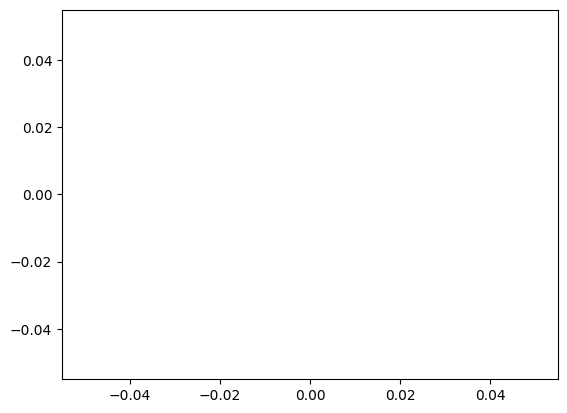


---------fold0---------
train:70611 valid:11776 test:12090


----- Evaluating on test set -----
24/24 - 27s - loss: 6.1075 - categorical_accuracy: 0.0020 - top5_acc: 0.0197 - 27s/epoch - 1s/step


2025-04-20 16:49:41.565344: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2025-04-20 16:49:41.737952: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2025-04-20 16:50:22.518393: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2025-04-20 16:50:22.835322: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.



----- Test Results -----
Loss:                 6.1075
Categorical Accuracy:  0.0020
Top-5 Accuracy:        0.0197
Macro F1 Score:        0.0001
Micro F1 Score:        0.0021


========== FINAL TEST RESULTS ACROSS ALL FOLDS ==========
Averaged across 1 folds:
Loss:                 6.1075
Categorical Accuracy:  0.0020
Top-5 Accuracy:        0.0197
Macro F1 Score:        0.0001
Micro F1 Score:        0.0021


[{'fold': 0,
  'results': {'loss': 6.107542514801025,
   'categorical_accuracy': 0.001985111739486456,
   'top5_acc': 0.019685691222548485,
   'macro_f1_score': 0.0001277106186102296,
   'micro_f1_score': 0.0020678246484698098}}]

In [64]:
# Start training and print results for 1 fold cross-validation. Model weights and results will be saved to Kaggle's working folder.
# Change model_int according to the model you want :
# 1: cnn_transformers_model
# 2: cnn_lstm_model
# 3: cnn_gru_model
# 4: cnn_model
# 5: transformers_model
# Default is cnn_transformers_model

train_folds(CFG, folds=[0], model_int=1)

Test: 24 files
Preprocessing...
Resample applied
Flip applied
Temporal crop applied
Spatial random affine applied
Temporal mask applied
Spatial mask applied

Model: "awp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 384, 708)]   0           []                               
                                                                                                  
 masking (Masking)              (None, 384, 708)     0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Dense)              (None, 384, 192)     135936      ['masking[0][0]']                
                                                                                                  
 stem_bn (BatchNormalization)   (None

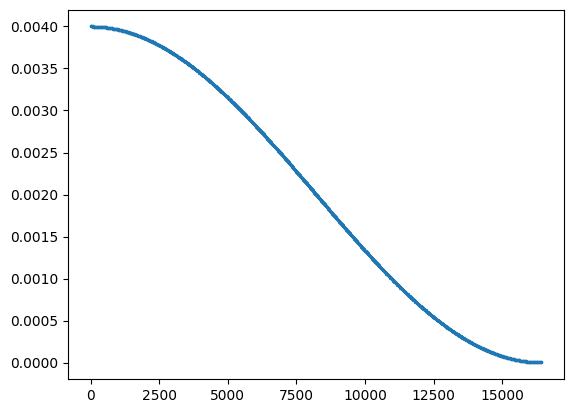



----- Evaluating on test set -----
24/24 - 27s - loss: 1.7630 - categorical_accuracy: 0.7843 - top5_acc: 0.9233 - 27s/epoch - 1s/step


2025-04-20 17:10:19.348362: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2025-04-20 17:10:19.531105: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2025-04-20 17:11:00.377733: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2025-04-20 17:11:00.702264: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.



----- Test Results -----
Loss:                 1.7630
Categorical Accuracy:  0.7843
Top-5 Accuracy:        0.9233
Macro F1 Score:        0.7806
Micro F1 Score:        0.7845


{'loss': 1.7629574537277222,
 'categorical_accuracy': 0.7842845320701599,
 'top5_acc': 0.9233250617980957,
 'macro_f1_score': 0.7805755120709428,
 'micro_f1_score': 0.7845326716294458}

In [79]:
# Make sure that the arguments for models_path and model_int correspond to model weights for the model type that you have trained.
# You can unzip the files in our results folder on our github, and load the best model weights (in .h5 files) for the model you want to test.
# Replace the path below with your own path to the best model weights.
model_path = '/kaggle/input/b/tensorflow2/default/1/islr-fp16-192-8-seed42-fold0-best.h5'

evaluate(CFG, model_path, model_int=1)